In [1]:
### check which version of python is used in Jupyter
import sys
print(sys.executable)
print(sys.version)

/Users/riyanandi/Desktop/ML/Apziva2/project2/bin/python3.11
3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.1.0.2.5)]


#### The objective of this notebook is to apply clustering algorithms for customer segmentation and analyze potential associations within the segmented groups. ####

### 1. Import Data ###

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

data=pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### 2. Categorical Data Transformation ###

In [3]:
#separate different columns
binary_cols=['default','housing','loan','y']
onehot_cols=['contact','job','marital','month']
ordinal_cols=['education']

In [4]:
# different categories have to be transformed differently
#binary transform

# Define map values
mapping = {'yes': 1,
           'no': 0}

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data
    
# Call function
binarised_df = binarise_values(data, binary_cols, mapping)
binarised_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [5]:
#onehot and ordinal transform
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

education_rank = [['unknown', 'primary', 'secondary','tertiary']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

#Define onehot encoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [6]:
numerical_cols_df=binarised_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Encode ordinals and create dfs
ord_encoded = ord_encoder.fit_transform(binarised_df[ordinal_cols])
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = ordinal_cols

# One-hot encoding
one_hot_encoded = ohe_encoder.fit_transform(binarised_df[onehot_cols])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = ohe_encoder.get_feature_names_out()

# Reset the index for all DataFrames to ensure alignment
numerical_cols_df = numerical_cols_df.reset_index(drop=True)
ord_encoded_df = ord_encoded_df.reset_index(drop=True)
one_hot_encoded_df = one_hot_encoded_df.reset_index(drop=True)

# Join encoded dfs to a single df and show head
df_encoded = pd.concat([numerical_cols_df,ord_encoded_df,one_hot_encoded_df], axis=1)
df_encoded.head()

,age,default,balance,housing,loan,day,duration,campaign,y,education,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,0,2143,1,0,5,261,1,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,44,0,29,1,0,5,151,1,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33,0,2,1,1,5,76,1,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,47,0,1506,1,0,5,92,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,33,0,1,0,0,5,198,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 3. Select rows where customers signed up for the term deposit ###

In [7]:
data_pos=df_encoded.loc[df_encoded['y']==1]
X=data_pos.drop(['y'],axis=1)
print(len(X))
X.head()

2896


,age,default,balance,housing,loan,day,duration,campaign,education,contact_cellular,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
83,59,0,2343,1,0,5,1042,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86,56,0,45,0,0,5,1467,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
87,41,0,1270,1,0,5,1389,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
129,55,0,2476,1,0,5,579,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
168,54,0,184,0,0,5,673,2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 4. Box plots and scatter plots ###

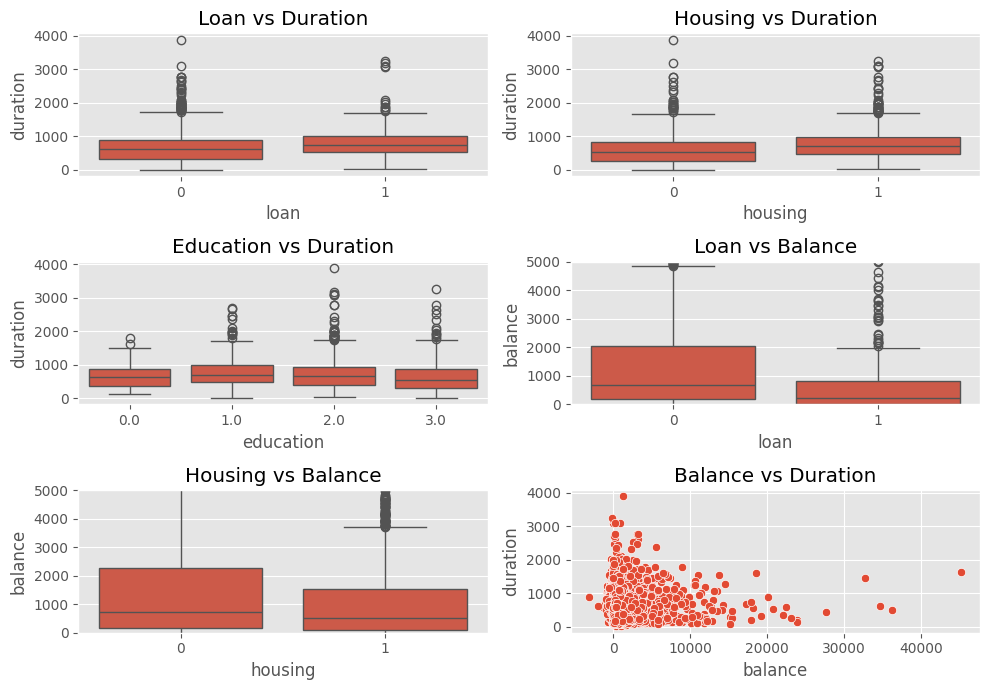

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(3, 2, figsize=(10, 7))  # Adjust figsize as needed for better visualization

# Plot each box plot separately
sns.boxplot(x="loan", y="duration", data=data_pos, ax=axes[0, 0])
axes[0, 0].set_title('Loan vs Duration')

sns.boxplot(x="housing", y="duration", data=data_pos, ax=axes[0, 1])
axes[0, 1].set_title('Housing vs Duration')

sns.boxplot(x="education", y="duration", data=data_pos, ax=axes[1, 0])
axes[1, 0].set_title('Education vs Duration')

sns.boxplot(x="loan", y="balance", data=data_pos, ax=axes[1, 1])
axes[1, 1].set_title('Loan vs Balance')
axes[1, 1].set_ylim(0,5000)

sns.boxplot(x="housing", y="balance", data=data_pos, ax=axes[2, 0])
axes[2, 0].set_title('Housing vs Balance')
axes[2, 0].set_ylim(0,5000)

sns.scatterplot(x="balance", y="duration", data=data_pos, ax=axes[2, 1])
axes[2, 1].set_title('Balance vs Duration')

plt.tight_layout()
plt.show()

### 5. K-Means Clustering ###

#### 5.1 Select optimal number of clusters ####

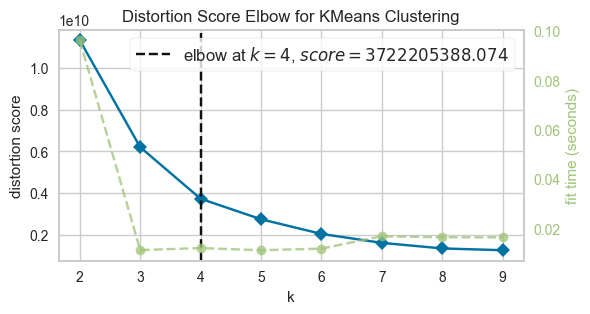

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

seed=98

plt.figure(figsize=(6,3))
# Instantiate the clustering model and visualizer
#
km = KMeans(random_state=seed)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

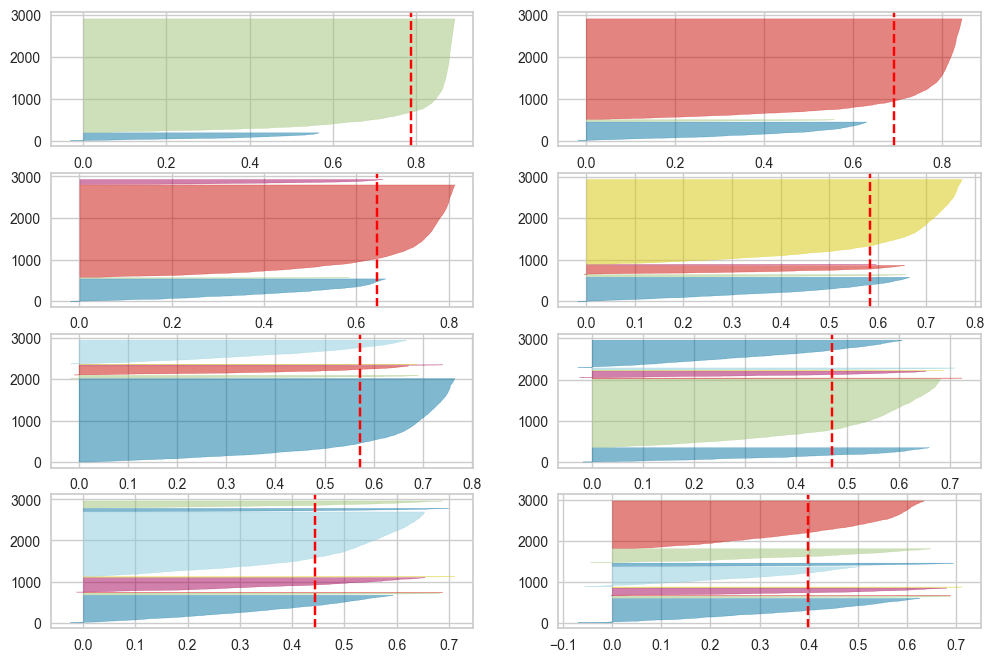

In [10]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(12,8))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=seed)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X) 

#### 5.2 Apply K-means clustering ####

In [15]:
from sklearn.cluster import KMeans

# Step 1: Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=seed) 
X['clusters']=kmeans.fit_predict(X)
X.head()

,age,default,balance,housing,loan,day,duration,campaign,education,contact_cellular,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,clusters
83,59,0,2343,1,0,5,1042,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
86,56,0,45,0,0,5,1467,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
87,41,0,1270,1,0,5,1389,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
129,55,0,2476,1,0,5,579,1,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
168,54,0,184,0,0,5,673,2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2


#### 5.3 Applying Principal Component Analysis ####

[0.97873476 0.02124211]


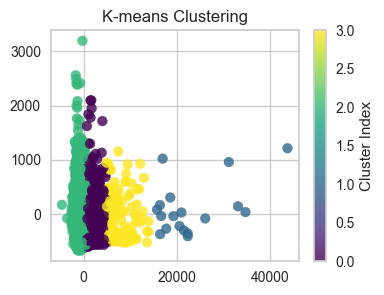

In [65]:
plt.figure(figsize=(4,3))

# We can use PCA for dimensionality reduction to visualize the clusters in 2D
from sklearn.decomposition import PCA

# Drop the 'clusters' column for PCA
X_no_clusters = X.drop(columns=['clusters'])

pca = PCA(n_components=2)
data_reduced = pca.fit_transform(X_no_clusters)

# check how much variance is explained by each principal component
print(pca.explained_variance_ratio_)

results = pd.DataFrame(data_reduced,columns=['pca1','pca2'])

plt.scatter(results['pca1'], results['pca2'],alpha=0.8,c=X['clusters'],cmap='viridis')
# Add a colorbar to indicate the clusters
plt.colorbar(label='Cluster Index')
plt.title('K-means Clustering')
plt.show()

The total variance in the data is explained 98% by the Principal Component 1

In [67]:
# Get the components (loadings)
components = pca.components_

# Create a DataFrame for better readability
feature_contributions = pd.DataFrame(components.T, 
                                     columns=[f'PC{i+1}' for i in range(components.shape[0])], 
                                     index=X_no_clusters.columns)

# Display the contribution of each feature to the first principal component (PC1)
print("Contribution of each feature to PC1:")
print(feature_contributions['PC1'].sort_values(ascending=False))

Contribution of each feature to PC1:
balance              9.999804e-01
age                  3.199395e-04
day                  4.145985e-05
month_nov            1.078839e-05
job_management       1.016744e-05
education            7.819466e-06
contact_telephone    7.281537e-06
campaign             6.377006e-06
job_retired          4.450087e-06
job_technician       3.930716e-06
month_feb            2.593455e-06
marital_single       2.422300e-06
month_mar            2.400260e-06
month_oct            2.348018e-06
marital_married      2.158761e-06
month_aug            1.762786e-06
month_apr            1.341179e-06
job_unknown          1.132194e-06
job_entrepreneur     9.578136e-07
job_self-employed    3.217497e-07
job_student          2.344179e-07
job_housemaid        9.613032e-08
month_dec           -2.345620e-08
job_unemployed      -1.193219e-06
month_jan           -1.427998e-06
month_jun           -1.514232e-06
contact_cellular    -2.991393e-06
default             -3.379205e-06
contact_unk

In [82]:
# Display the contribution of each feature to the second principal component (PC2)
print("Contribution of each feature to PC1:")
print(feature_contributions['PC2'].sort_values(ascending=False))

Contribution of each feature to PC1:
duration             9.999802e-01
balance              6.248641e-03
campaign             6.123697e-04
housing              2.056160e-04
contact_unknown      1.829131e-04
month_jul            1.324951e-04
job_blue-collar      9.154905e-05
month_may            8.366563e-05
loan                 8.356597e-05
month_aug            6.881727e-05
job_services         3.916300e-05
month_jun            2.903457e-05
month_nov            2.787812e-05
marital_divorced     2.708633e-05
month_jan            2.550975e-05
job_entrepreneur     1.102415e-05
job_housemaid        1.011099e-05
job_self-employed    9.985240e-06
marital_married      9.284910e-06
job_unemployed       5.992645e-06
default             -5.468242e-07
month_dec           -1.055909e-06
job_unknown         -3.480838e-06
job_technician      -1.444365e-05
contact_telephone   -2.746096e-05
job_admin           -2.769140e-05
month_oct           -3.010516e-05
job_retired         -3.156696e-05
job_student

#### 5.4 Associations based on the clusters ####

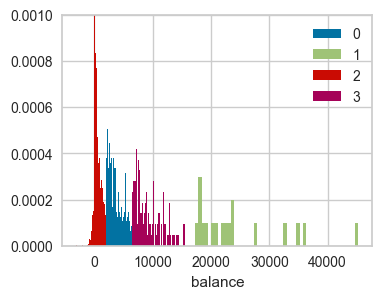

In [76]:
plt.figure(figsize=(4,3))

plt.hist(X[X['clusters']==0]['balance'],density=True,bins=50,label='0')
plt.hist(X[X['clusters']==1]['balance'],density=True,bins=50,label='1')
plt.hist(X[X['clusters']==2]['balance'],density=True,bins=50,label='2')
plt.hist(X[X['clusters']==3]['balance'],density=True,bins=50,label='3')
plt.xlabel('balance')
plt.ylim(0,0.001)
plt.legend(loc='best');

(0.0, 1000.0)

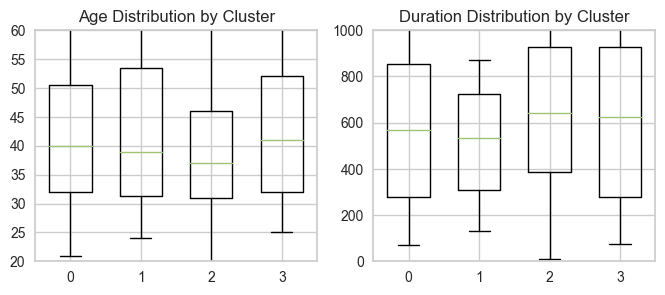

In [79]:
plt.figure(figsize=(8,3))

# First plot
plt.subplot(1, 2, 1)
for cluster in clusters:
    plt.boxplot(X[X['clusters'] == cluster]['age'], positions=[cluster], widths=0.6)
plt.title('Age Distribution by Cluster')
plt.ylim(20,60)

plt.subplot(1, 2, 2)
for cluster in clusters:
    plt.boxplot(X[X['clusters'] == cluster]['duration'], positions=[cluster], widths=0.6)
plt.title('Duration Distribution by Cluster')
plt.ylim(0,1000)

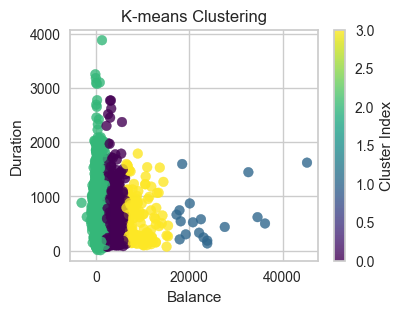

In [81]:
plt.figure(figsize=(4,3))
plt.scatter(X['balance'], X['duration'],alpha=0.8,c=X['clusters'],cmap='viridis')
# Add a colorbar to indicate the clusters
plt.colorbar(label='Cluster Index')
plt.title('K-means Clustering')
plt.xlabel('Balance')
plt.ylabel('Duration')
plt.show()

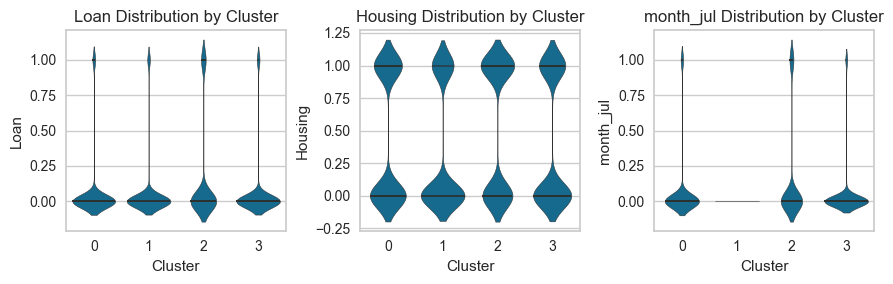

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 3))  # Adjust the figure size for three side-by-side plots

# First plot
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.violinplot(x=X['clusters'], y=X['loan'], inner='stick', bw_method=0.2)
plt.xlabel('Cluster')
plt.ylabel('Loan')
plt.title('Loan Distribution by Cluster')

# Second plot (you can use similar or different data)
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.violinplot(x=X['clusters'], y=X['housing'], inner='stick', bw_method=0.2)  # Replace 'another_feature'
plt.xlabel('Cluster')
plt.ylabel('Housing')
plt.title('Housing Distribution by Cluster')

# Third plot (again, similar or different)
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.violinplot(x=X['clusters'], y=X['month_jul'], inner='stick', bw_method=0.2)  # Replace 'yet_another_feature'
plt.xlabel('Cluster')
plt.ylabel('month_jul')
plt.title('month_jul Distribution by Cluster')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


### 6. Hierarchical Clustering ###

In [76]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Perform hierarchical clustering
#X_new=X.drop(['clusters'],axis=1)
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
X['hc_clusters'] = hc.fit_predict(X)

# Display the first few rows of the dataframe with cluster labels
print(X.head())

     age  default  balance  housing  loan  day  duration  campaign  education  \
83    59        0     2343        1     0    5      1042         1        2.0   
86    56        0       45        0     0    5      1467         1        2.0   
87    41        0     1270        1     0    5      1389         1        2.0   
129   55        0     2476        1     0    5       579         1        2.0   
168   54        0      184        0     0    5       673         2        3.0   

     contact_cellular  ...  month_dec  month_feb  month_jan  month_jul  \
83                0.0  ...        0.0        0.0        0.0        0.0   
86                0.0  ...        0.0        0.0        0.0        0.0   
87                0.0  ...        0.0        0.0        0.0        0.0   
129               0.0  ...        0.0        0.0        0.0        0.0   
168               0.0  ...        0.0        0.0        0.0        0.0   

     month_jun  month_mar  month_may  month_nov  month_oct  hc_clust

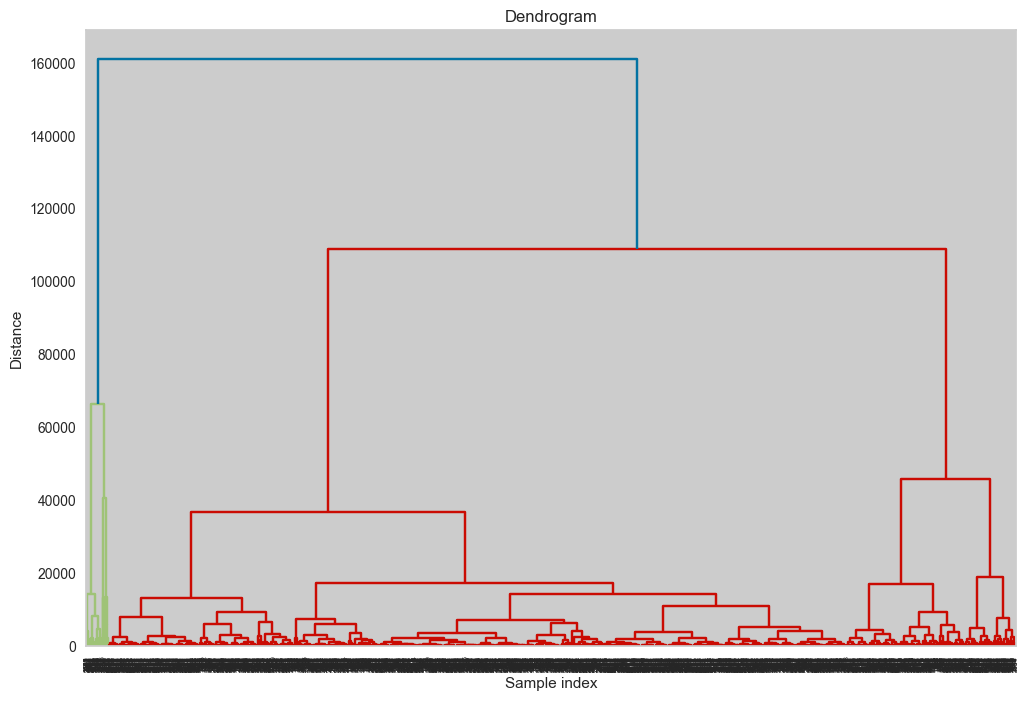

In [77]:
# Compute the linkage matrix
linkage_matrix = sch.linkage(X, method='ward', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

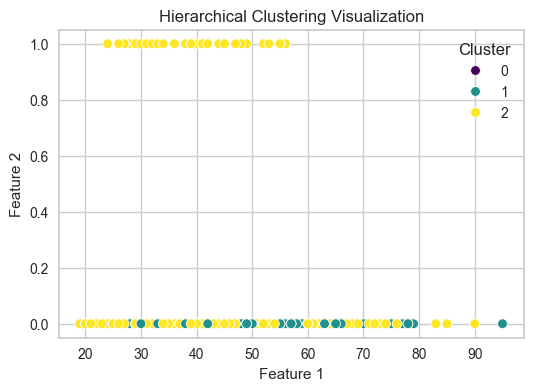

In [78]:
# Create a scatter plot for the hierarchical clusters
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue='hc_clusters', data=X, palette='viridis')
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('Feature 1')  # Adjust as needed
plt.ylabel('Feature 2')  # Adjust as needed
plt.legend(title='Cluster')
plt.show()

### 7. CONCLUSION ###

The most efficient way to segment customers for this problem is based on their balance. Customers with lower balance have higher call durations and while for people with higher balance, the call durations are often short.